# Performing model-based robust optimization for the cross-resonance gate
**Increasing robustness against crosstalk in a two-qubit entangling operation**

Boulder Opal provides tools to simplify the process of [control optimization](https://docs.q-ctrl.com/boulder-opal/tutorials/design-robust-single-qubit-gates-using-computational-graphs) even for complex multiqubit systems.  Superconducting qubits in particular have been shown to benefit from the application of robust control solutions for the suppression of drift and crosstalk-induced errors endemic to real hardware.  With an appropriate Hamiltonian model of the system it's possible to create noise-robust control solutions which ultimately deliver improved gate fidelity as a means to increase quantum volume.

In this application note we will demonstrate the utility of robust control to improve the performance of cross-resonance entangling gates degraded by crosstalk errors.  We will cover:
- Modelling crosstalk as a noise channel
- Performing model-based control optimization on a pair of coupled multilevel systems
- Validating performance by calculating susceptibility to quasi-static crosstalk errors

Ultimately this notebook demonstrates how to improve the quantum volume of superconducting quantum computers by delivering gate-level performance enhancements.

## Imports and initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qctrlvisualizer as qv

import boulderopal as bo

plt.style.use(qv.get_qctrl_style())

colors = {
    "Primitive": "black",
    "Optimized": qv.QCTRL_STYLE_COLORS[0],
    "Robust": qv.QCTRL_STYLE_COLORS[1],
}

## Creating a Boulder Opal cross-resonance gate robust to crosstalk
Consider a system of two transmon qubits coupled by a common transmission line. Qubit 1 is defined as the control qubit, and qubit 2 is the target qubit. The control qubit is driven by the in-phase and quadrature microwave drive with a frequency that matches the target qubit frequency. In a frame rotating with the drive frequency and after applying the rotating wave approximation (RWA) the Hamiltonian is of the form:

$$
\frac{1}{\hbar} H = (\Delta + \epsilon) b_1^\dagger b_1 +
\frac{\alpha_1}{2} (b_1^\dagger)^2 b_1^2 +
\epsilon b_2^\dagger b_2+
\frac{\alpha_2}{2} (b_2^\dagger)^2 b_2^2 +
 g \left( b_1^\dagger b_2 + b_1 b_2^\dagger \right) +\frac{1}{2}\left(\Omega(t)b_1 + \text{H.c.}\right),
$$

where $b_i$ is the annihilation operator of the $i$th qubit, $\Delta=\omega_1-\omega_2$ is the detuning between the two qubits where $\omega_i$ is the frequency of the $i$th qubit, $\epsilon$ is the mismatch between the drive frequency and the target qubit frequency, $g$ is the effective coupling strength between the qubits, $\Omega$ is the drive modulus and $\alpha_i$ is the anharmonicity of the $i$th qubit.

The target operation is the $\pi/2$ cross-resonance gate which operates in the space of the two lowest levels:

$$U_\mathrm{CR}\left(\frac{\pi}{2}\right)=\frac{1}{\sqrt{2}}\left(\mathbb{I}-i\sigma_1^z\sigma_2^x\right)=[ZX]^{1/2}.$$

Since the above operation is defined up to phase factors of the individual qubits, this may lead to a large infidelity. Consequently, a final (optimizable) phase shift on each qubit is introduced to overcome the infidelity inflation due to these phase factors.

This application note addresses robustness to crosstalk. Crosstalk between the qubits leads to unwanted effects that may mimic the effect of noise. The crosstalk Hamiltonian has the form
$$
\frac{1}{\hbar} H_\mathrm{ct}
  = c_\mathrm{ct}
  \frac{\Omega(t)}{2}b_2 + \text{H.c.},
$$
where $c_\mathrm{ct}$ is the (complex) relative crosstalk.

In this section, we optimize the implementation of the target gate under the effect of crosstalk. This is performed within the framework of the four-level approximation, where only the first four levels of each qubit are considered. Moreover, only up to three excitations overall are permitted, which further reduces the Hilbert space from $16$ states to $10$ states.

To set up the optimization, first define operators and constants.

In [2]:
# Constants in the lab frame.
omega_1 = 5.114 * 2 * np.pi * 1e9  # Hz
omega_2 = 4.914 * 2 * np.pi * 1e9  # Hz
alpha_1 = -330 * 2 * np.pi * 1e6  # Hz
alpha_2 = -330 * 2 * np.pi * 1e6  # Hz
g = 3.8 * 2 * np.pi * 1e6  # Hz
Delta = omega_1 - omega_2
epsilon = 0

# Limits for drive amplitudes.
drive_max = 200 * 2 * np.pi * 1e6  # Hz

Next, define the operators in the Hamiltonian and the target gate. The target gate is defined in the dressed frame, that is, the basis where the constant Hamiltonian term

$$
\frac{1}{\hbar} H_0 = (\Delta + \epsilon) b_1^\dagger b_1 +
\frac{\alpha_1}{2} (b_1^\dagger)^2 b_1^2 +
\epsilon b_2^\dagger b_2+
\frac{\alpha_2}{2} (b_2^\dagger)^2 b_2^2 +
 g \left( b_1^\dagger b_2 + b_1 b_2^\dagger \right),
$$

is diagonal. The transformation between the frames is defined through $H_0 S = S D$, with the unitary operator $S$.

In [3]:
# Lowering operator.
b = np.diag(np.sqrt(np.arange(1, 4)), 1)
# Number operator.
n = np.diag(np.arange(4))
# Projector onto the two lowest states.
qubit_proj = np.diag([1, 1, 0, 0])

# Pauli operators.
sigma_x = np.zeros(n.shape)
sigma_x[:2, :2] = np.array([[0, 1], [1, 0]])
sigma_z = np.zeros(n.shape)
sigma_z[:2, :2] = np.array([[1, 0], [0, -1]])

# Embedding the single-qubit number operators into the two-qubit system of dimension 16.
n1 = np.kron(n, np.eye(4))
n2 = np.kron(np.eye(4), n)

proj = np.kron(qubit_proj, qubit_proj)

# Block-diagonal permutations. We find the indices of the 10 two-qutrit
# states with the fewest total excitations. This truncates the
# Hilbert space to a total of three excitations or less.
perm = np.argsort(np.diag(n1 + n2))
perm_trunc = perm[:10]
block_n = [np.where(np.diag(n1 + n2) == n)[0].tolist() for n in range(4)]
truncate = np.ix_(perm_trunc, perm_trunc)

# Define truncated operators.
b_1 = np.kron(b, np.eye(4))[truncate]
bd_1 = b_1.T.conj()
b_2 = np.kron(np.eye(4), b)[truncate]
bd_2 = b_2.T.conj()
bdb_1 = n1[truncate]
bdb_2 = n2[truncate]
bdb_12 = np.kron(b.T.conj(), b)[truncate]
bdb_21 = np.kron(b, b.T.conj())[truncate]
bd2b2_1 = (n1 @ n1 - n1)[truncate]
bd2b2_2 = (n2 @ n2 - n2)[truncate]

sigma_z_1 = np.kron(sigma_z, np.eye(4))[truncate]
sigma_z_2 = np.kron(np.eye(4), sigma_z)[truncate]

# Frame transformation HS = SD.
hamiltonian_with_no_drives = (
    (Delta + epsilon) * bdb_1
    + epsilon * bdb_2
    + alpha_1 * bd2b2_1 / 2
    + alpha_2 * bd2b2_2 / 2
    + g * (bdb_12 + bdb_21)
)
S = np.eye(10)
base_index = 0
for i in block_n:
    inds = np.arange(base_index, base_index + len(i))
    eigenvalues, eigenvectors = np.linalg.eigh(
        hamiltonian_with_no_drives[:, inds][inds, :]
    )
    for k, j in enumerate(eigenvectors.T):
        ind = np.abs(np.abs(j) - 1.0).argmin()
        S[:, base_index + ind][inds] = j * np.sign(j[ind])
    base_index += len(i)

# The phase shift operators in the simulation/optimization frame.
phase_shift_operator1 = S @ (sigma_z_1 / 2) @ S.T.conj()
phase_shift_operator2 = S @ (sigma_z_2 / 2) @ S.T.conj()

# Target in the simulation/optimization frame.
zx_half = np.linalg.multi_dot(
    [S, ((proj - 1j * np.kron(sigma_z, sigma_x)) / np.sqrt(2))[truncate], S.T.conj()]
)

### Creating control pulses

Next, define the optimization configuration and the control schemes: Primitive, Optimized and Robust.

In [4]:
# Optimization constraints.
duration = 0.4e-6  # s
crosstalk_constant = 0.1

scheme_configurations = {
    "Primitive": {
        "primitive_flag": True,
        "noise_flag": False,
        "segment_count": 1,
        "optimization_count": 10,
    },
    "Optimized": {
        "primitive_flag": False,
        "noise_flag": False,
        "segment_count": 200,
        "optimization_count": 4,
    },
    "Robust": {
        "primitive_flag": False,
        "noise_flag": True,
        "segment_count": 200,
        "optimization_count": 4,
    },
}

The optimization specification in the next cell involves several steps:
- create the (noiseless) Hamiltonian,
- create the noise operators,
- define the cost function to be minimized by the optimizer, which is the infidelity of the system's evolution,
- introduce the final (optimizable) phase shift on each qubit,
- compute the infidelity of the Hamiltonian with optimizable phase shifts.

The outputs are the optimized values of $\Omega(t)$ ($x$ and $y$ components) across the gate duration, the optimized phase shifts, and the infidelities with and without the phase shifts.

In [5]:
def scheme_optimization(primitive_flag, noise_flag, segment_count, optimization_count):
    graph = bo.Graph()

    # Construct drive term.
    if primitive_flag:
        drive = graph.real_optimizable_pwc_signal(
            segment_count=segment_count,
            duration=duration,
            maximum=drive_max,
            minimum=-drive_max,
            name="drive",
        )
    else:
        drive = graph.complex_optimizable_pwc_signal(
            segment_count=segment_count,
            duration=duration,
            maximum=drive_max,
            name="drive",
        )

    drive_term = graph.hermitian_part(drive * b_1)

    # Construct remaining Hamiltonian term.
    fixed_hamiltonian_term = (
        (Delta + epsilon) * bdb_1
        + epsilon * bdb_2
        + alpha_1 * bd2b2_1 / 2
        + alpha_2 * bd2b2_2 / 2
        + g * (bdb_12 + bdb_21)
    )

    hamiltonian = drive_term + fixed_hamiltonian_term

    # Create noise operators.
    if noise_flag:
        crosstalk_1x = crosstalk_constant * graph.real(drive) * (b_2 + bd_2) / 2
        crosstalk_1y = crosstalk_constant * graph.imag(drive) * 1j * (b_2 - bd_2) / 2
        noise_operators = [crosstalk_1x, crosstalk_1y]
    else:
        noise_operators = []

    # Create infidelity.
    infidelity = graph.infidelity_pwc(
        hamiltonian=hamiltonian,
        noise_operators=noise_operators,
        target=graph.target(operator=zx_half),
        name="infidelity",
    )

    # Introduce optimizable phase shifts on each qubit.
    phase_shifts = graph.optimization_variable(
        count=2,
        lower_bound=-np.pi,
        upper_bound=np.pi,
        is_lower_unbounded=True,
        is_upper_unbounded=True,
        name="phases",
    )
    phase_shift_hamiltonian = graph.constant_pwc(
        phase_shifts[0] * phase_shift_operator1
        + phase_shifts[1] * phase_shift_operator2,
        duration=1.0,
    )

    u_phase = graph.time_evolution_operators_pwc(
        hamiltonian=phase_shift_hamiltonian, sample_times=np.array([1.0])
    )
    # Create infidelity with phase shifts
    cost = graph.infidelity_pwc(
        hamiltonian=hamiltonian,
        noise_operators=noise_operators,
        target=graph.target(operator=u_phase[0] @ zx_half),
        name="infidelity_with_phase_shift",
    )

    return bo.run_optimization(
        graph=graph,
        optimization_count=optimization_count,
        cost_node_name="infidelity_with_phase_shift",
        output_node_names=[
            "infidelity",
            "infidelity_with_phase_shift",
            "drive",
            "phases",
        ],
    )

Next, perform the optimization. The following cell optimizes a primitive pulse as a benchmark, along with the optimized and the robust controls. The infidelities for each control scheme are presented with and without the phase shift.

In [6]:
scheme_results = {}

for scheme, config in scheme_configurations.items():
    scheme_results[scheme] = scheme_optimization(**config)

for scheme, result in scheme_results.items():
    print(f"\n\t{scheme}")
    print(f"Infidelity: {result['output']['infidelity']['value']:.3e}")
    print(
        "Infidelity with phase shift: "
        f"{result['output']['infidelity_with_phase_shift']['value']:.3e}"
    )

Your task (action_id="1828083") has started.
Your task (action_id="1828083") has completed.
Your task (action_id="1828088") has started.
Your task (action_id="1828088") has completed.
Your task (action_id="1828091") has started.
Your task (action_id="1828091") has completed.

	Primitive
Infidelity: 7.321e-01
Infidelity with phase shift: 1.825e-01

	Optimized
Infidelity: 4.963e-01
Infidelity with phase shift: 4.383e-07

	Robust
Infidelity: 5.529e-01
Infidelity with phase shift: 3.921e-05


Even in the presence of crosstalk, the infidelity arising from the robust pulse (with phase shifts) is extremely low. Visualize the control schemes using the cell below.

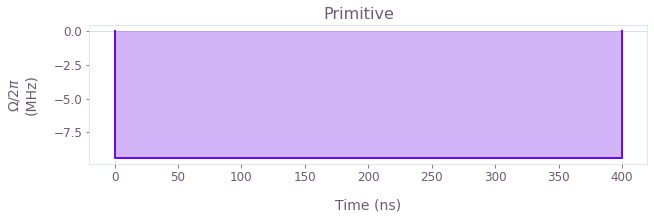

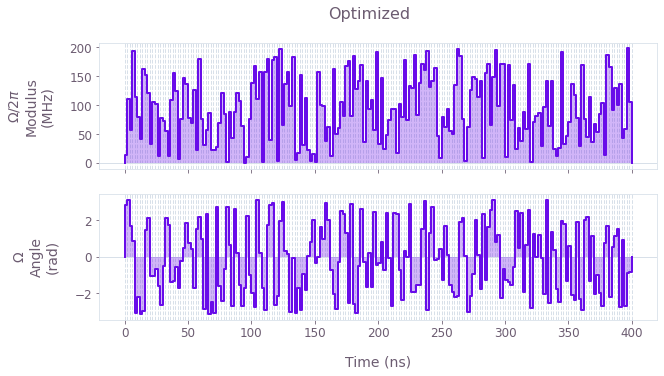

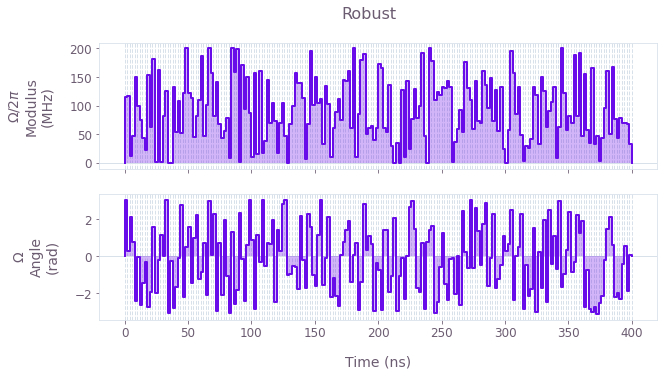

In [7]:
for scheme, result in scheme_results.items():
    qv.plot_controls({"$\\Omega$": result["output"]["drive"]})
    plt.suptitle(scheme)
    plt.show()

The above plots display the control pulses ($\Omega_x$ and $\Omega_y$) for the primitive, optimized and robust schemes, respectively.

## Verifying accuracy and robustness of Boulder Opal cross-resonance gate

Use the controls obtained above to calculate the exact time evolution determined by the Hamiltonian in the four-level approximation. In the cell below, the evolution dynamics is calculated for each scheme with a batch of crosstalk amplitudes. We then extract both the noise-free and the noisy dynamics from the result.

First, verify the noise-free operations: compare the noise-free operational infidelities and examine the evolution of an equal superposition of the four lowest 2-qubit states, $|\psi_0\rangle =\frac{1}{2}\left(|00\rangle-i|01\rangle+i|10\rangle+|11\rangle\right)$.

In [8]:
initial_state = (np.array([[1, -1j, 1j, 0, 1, 0, 0, 0, 0, 0]]) / 2).T
crosstalk_count = 101
crosstalk_array = np.linspace(-1, 1, crosstalk_count)
scheme_infidelities = {}
scheme_probabilities = {}

for scheme, result in scheme_results.items():
    graph = bo.Graph()

    # Construct drive term.
    drive_values = result["output"]["drive"]["values"]
    drive = graph.pwc_signal(values=drive_values, duration=duration)
    drive_term = graph.hermitian_part(drive * b_1)

    # Construct crosstalk terms.
    drive_batched = graph.pwc_signal(
        values=drive_values * crosstalk_array[:, None], duration=duration
    )
    crosstalk_1x = crosstalk_constant * graph.real(drive_batched) * (b_2 + bd_2) / 2
    crosstalk_1y = (
        crosstalk_constant * graph.imag(drive_batched) * 1j * (b_2 - bd_2) / 2
    )

    # Construct remaining Hamiltonian terms.
    fixed_hamiltonian_term = (
        (Delta + epsilon) * bdb_1
        + epsilon * bdb_2
        + alpha_1 * bd2b2_1 / 2
        + alpha_2 * bd2b2_2 / 2
        + g * (bdb_12 + bdb_21)
    )

    # Generate Hamiltonian and evolution operator.
    hamiltonian = crosstalk_1x + crosstalk_1y + drive_term + fixed_hamiltonian_term

    u_H = graph.time_evolution_operators_pwc(
        hamiltonian=hamiltonian, sample_times=np.array([duration])
    )

    # Construct phase correction terms.
    phase1 = result["output"]["phases"]["value"][0]
    phase2 = result["output"]["phases"]["value"][1]
    phase_shift_hamiltonian = graph.constant_pwc(
        phase1 * phase_shift_operator1 + phase2 * phase_shift_operator2, duration=1.0
    )
    u_phase = graph.time_evolution_operators_pwc(
        hamiltonian=phase_shift_hamiltonian, sample_times=np.array([1.0])
    )

    # Obtain infidelity.
    infidelity_with_phase_shift = graph.unitary_infidelity(
        u_H[:, -1], u_phase[0] @ zx_half, name="infidelity"
    )

    # Obtain noise-free state evolution.
    final_unitary = graph.conjugate(u_phase) @ u_H
    final_state = final_unitary[crosstalk_count // 2, 0] @ initial_state
    probabilities = graph.abs(final_state[:, 0]) ** 2
    probabilities.name = "probabilities"

    # Calculate simulation.
    graph_result = bo.execute_graph(
        graph=graph, output_node_names=["infidelity", "probabilities"]
    )

    scheme_infidelities[scheme] = graph_result["output"]["infidelity"]["value"]
    scheme_probabilities[scheme] = graph_result["output"]["probabilities"]["value"]

print("\nNoise-free operational infidelities")
for scheme, infidelity in scheme_infidelities.items():
    print(f"\t{scheme:10s}:\t{infidelity[crosstalk_count // 2]:.3e}")

Your task (action_id="1828096") has completed.
Your task (action_id="1828098") has started.
Your task (action_id="1828098") has completed.
Your task (action_id="1828099") has started.
Your task (action_id="1828099") has completed.

Noise-free operational infidelities
	Primitive :	1.825e-01
	Optimized :	4.383e-07
	Robust    :	2.576e-07


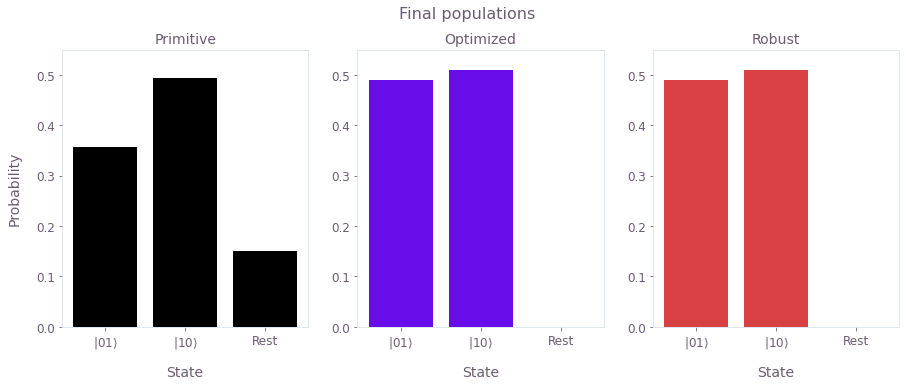

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Final populations", y=1)

for ax, (scheme, probs) in zip(axs, scheme_probabilities.items()):
    populations = [probs[1], probs[2], 1 - probs[1] - probs[2]]
    ax.bar(
        [r"$|01\rangle$", r"$|10\rangle$", "Rest"], populations, color=colors[scheme]
    )
    ax.set_ylim(0.0, 0.55)
    ax.set_title(scheme)
    ax.set_xlabel("State")

axs[0].set_ylabel("Probability")
plt.show()

The figure shows the final state after operating the respective gates on the initial state $|\psi_0\rangle =\frac{1}{2}\left(|00\rangle-i|01\rangle+i|10\rangle+|11\rangle\right)$. The final state after an ideal operation of the CR gate should be the Bell state $|\psi_f\rangle =\frac{1}{\sqrt{2}}\left(|01\rangle+|10\rangle\right)$. The populations are displayed to assess each scheme. Clearly, there is non-negligible population leakage in the primitive scheme, while both the Optimized and Robust schemes perform almost perfectly (up to a small asymmetry).

Next, assess the robustness of the different control solutions to crosstalk noise.

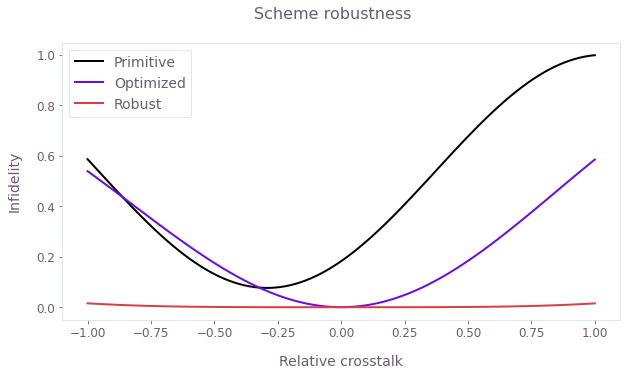

In [10]:
plt.suptitle("Scheme robustness")
for scheme, infidelity in scheme_infidelities.items():
    plt.plot(crosstalk_array, infidelity, label=scheme, color=colors[scheme])
plt.legend()
plt.xlabel("Relative crosstalk")
plt.ylabel("Infidelity")
plt.show()

The figure demonstrates the different noise (crosstalk) susceptibilities (in terms of operational infidelity) of the Primitive, Optimized and Robust controls. The Robust scheme has a much broader low-infidelity region.